In [1]:
import sys
import os
import jax
jax.config.update("jax_enable_x64", True)

# Add the models directory to the Python path
sys.path.append(os.path.join(os.getcwd(),'..', 'models'))

# Import the functions from transport_analytical.py
from transport_analytical import constant_injection, pulse_injection
from transport_analytical_jax import constant_injection as const_injection_jax
from transport_analytical_jax import pulse_injection as pulse_injection_jax
from transport_analytical_sympy import vec_pulse, vec_par_pulse
import juliacall

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [2]:
%%julia
include("../models/transport_analytical.jl")

# Benchmark of the Analytical Conservative Trasport Equation

I prepared the solution from Lapidus and Amundson (1952) to the best of my knowledge in three different frameworks:
- numpy/scipy
- jax
- julia

I already anticipate that the numpy solution is not the fastest because there is an inner loop in pure python. I am trying to improve that. I also did not include a numba solution for now because I need to use the special function from scipy `erfc` which requires more work done to adapt it.

## Parameters and Array Values

To perform the transport analysis, we need to define the following parameters and array values:

- `Dl`: The dispersion coefficient [L^2/T]
- `v`: The velocity of the fluid [L/T]
- `L`: The length of the domain [L]
- `T`: The total time of the analysis  [T]
- `N`: The number of grid points
- `x`: The array of spatial coordinates [L]
- `c0`: The initial concentration [M/L^3]
- `c_in`: The concentration at the inlet [M/L^3]

Let's define these parameters and array values:

In [3]:
import numpy as np
x = np.linspace(0, 0.5, 100)
t = np.linspace(0.1, 72000, 100)
c0 = 1.
c_in = 0.
v = 1e-5
alpha_l = 1e-3
De = 1e-9
phi = 0.3
Dl = 1e-9 + alpha_l*v
t_pulse = 3600
crnp = np.zeros((len(t), len(x)))


In [4]:
%%julia
x = range(0, stop=0.5, length=100)
t = range(0.1, stop=72000, length=100)
c0 = 1.0
c_in = 0.0
v = 1e-5
alpha_l = 1e-3
De = 1e-9
Dl = De + alpha_l * v
t_pulse = 3600.0
phi = 0.3
cr = zeros(length(x), length(t))    

100×100 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮              ⋱            ⋮                   
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

## Benchmarking the python and julia implementations over a range of velocities

Slow velocities: more diffusion dominated, fast velocities: more advection dominated.

Although for the analytical function, it is likely not to matter much.

In [5]:
qs = np.array([1e-3, 1e-4, 1e-5, 1e-6, 1e-7])
vs = qs / phi

In [6]:
%%julia
qs = [1e-3, 1e-4, 1e-5, 1e-6, 1e-7]
vs = qs ./ phi

5-element Vector{Float64}:
 0.0033333333333333335
 0.0003333333333333334
 3.3333333333333335e-5
 3.3333333333333333e-6
 3.3333333333333335e-7

In [7]:
#Checking solutions:

for v in vs:
    constant_injection(crnp, x, t, c0, c_in, v, alpha_l)
    cjax = const_injection_jax(x, t, c0, c_in, v, alpha_l)
    assert np.allclose(crnp, cjax, rtol=1e-6, atol=1e-6)

In [8]:
%%julia
for v in vs
    constant_injection(cr, collect(x), collect(t), c0, c_in, v, Dl)
end

In [9]:
import timeit
import timeit

# Time the Python function
ts_np = np.zeros_like(vs)
i = 0
for v in vs:
    ts_np[i] = timeit.timeit(lambda: constant_injection(crnp, x, t, c0, c_in, v, Dl), number=1000)
    ts_np[i] = ts_np[i] / 1000
    i += 1
print(ts_np)


c:\Users\vcant\Documents\rt1dhub\benchmarks\..\models\transport_analytical.py:27: RuntimeWarning: overflow encountered in exp
  + np.exp(v * x[i] / Dl)
c:\Users\vcant\Documents\rt1dhub\benchmarks\..\models\transport_analytical.py:27: RuntimeWarning: invalid value encountered in multiply
  + np.exp(v * x[i] / Dl)


[0.00145184 0.00140605 0.00134649 0.0012333  0.00120902]


In [10]:
# Time the Python function
ts_jax = np.zeros_like(vs)
i = 0
for v in vs:
    ts_jax[i] = timeit.timeit(lambda: const_injection_jax(x, t, c0, c_in, v, Dl).block_until_ready(), number=10000)
    ts_jax[i] = ts_jax[i] / 10000
    i += 1
print(ts_jax)

[1.3493905e-04 1.3436007e-04 1.2166246e-04 8.1844160e-05 8.9288490e-05]


In [11]:
%%julia
using BenchmarkTools

In [12]:
%%julia
ts = zeros(length(vs))
xc = collect(x)
tc = collect(t)
for (i, v) in enumerate(vs)
    ts[i] = @belapsed constant_injection(cr, xc, tc, c0, c_in, v, Dl)
end
ts

5-element Vector{Float64}:
 0.0003716
 0.0003688
 0.00037
 0.0003691
 0.000369

In [13]:
from juliacall import Main as jl

In [14]:
tjulia = jl.ts

In [15]:
tjulia

5-element Vector{Float64}:
 0.0003716
 0.0003688
 0.00037
 0.0003691
 0.000369

C:\Users\vcant\AppData\Local\Temp\ipykernel_17420\3148224209.py:32: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


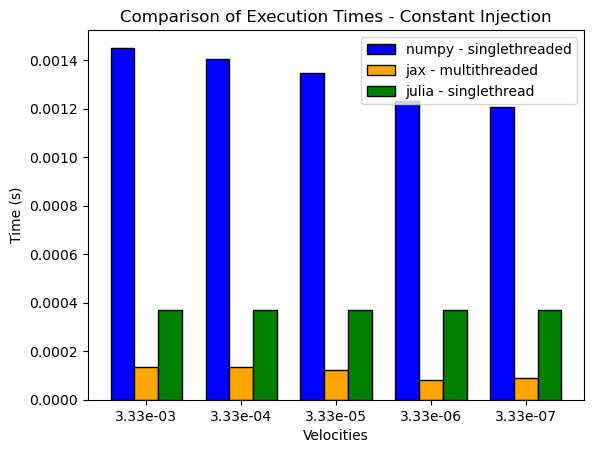

In [16]:
import matplotlib.pyplot as plt

# Define the data
labels = [np.format_float_scientific(v,2) for v in vs]


# Set the width of the bars
bar_width = 0.25

# Set the positions of the bars on the x-axis
r1 = np.arange(len(ts_np))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

fig, ax = plt.subplots()

# Create the bar plot
ax.bar(r1, ts_np, color='blue', width=bar_width, edgecolor='black', label='numpy - singlethreaded')
ax.bar(r2, ts_jax, color='orange', width=bar_width, edgecolor='black', label='jax - multithreaded')
ax.bar(r3, tjulia, color='green', width=bar_width, edgecolor='black', label='julia - singlethread')

# Add xticks and labels
ax.set_xlabel('Velocities')
ax.set_ylabel('Time (s)')
ax.set_title('Comparison of Execution Times - Constant Injection')
ax.set_xticks([r + bar_width for r in range(len(ts_np))], labels)

# Add a legend
ax.legend()

# Show the plot
fig.show()

## Now testing the pulse injection

In [19]:
t_pulse = 3600.
crnp = np.zeros((len(t), len(x)))
csym = np.zeros((len(t), len(x)))
csym_par = np.zeros((len(t), len(x)))
for v in vs:
    Dl = alpha_l*v + De
    pulse_injection(crnp, x, t, c0, c_in, v, Dl, t_pulse)
    cjax = pulse_injection_jax(x, t, c0, c_in, v, Dl, t_pulse)
    vec_pulse(csym, x, t, c0, c_in,phi, v*phi ,De, alpha_l, t_pulse)
    vec_par_pulse(csym_par, x, t, c0, c_in,phi, v*phi ,De, alpha_l, t_pulse)
    assert np.allclose(crnp, cjax, rtol=1e-6, atol=1e-6)
    #assert np.allclose(crnp, csym, rtol=1e-6, atol=1e-6)

In [24]:
crnp

array([[0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       ...,
       [0.00000000e+000, 3.26691303e-003, 9.96834062e-003, ...,
        1.88227618e-253, 3.32698172e-259, 9.80122523e-265],
       [0.00000000e+000, 3.16966052e-003, 9.69279472e-003, ...,
        1.25083090e-250, 4.83118081e-256, 8.54610753e-262],
       [0.00000000e+000, 3.07576327e-003, 9.42584733e-003, ...,
        7.28758162e-248, 3.21247863e-253, 6.49750403e-259]])

In [25]:
# Time the Python function
ts_jax = np.zeros_like(vs)
ts_np = np.zeros_like(vs)
ts_sym = np.zeros_like(vs)
ts_sym_par = np.zeros_like(vs)
i = 0
for v in vs:
    ts_jax[i] = timeit.timeit(lambda: pulse_injection_jax(x, t, c0, c_in, v, Dl, t_pulse).block_until_ready(), number=10000)
    ts_jax[i] = ts_jax[i] / 10000
    ts_np[i] = timeit.timeit(lambda: pulse_injection(crnp, x, t, c0, c_in, v, Dl, t_pulse), number=1000)
    ts_np[i] = ts_np[i] / 1000
    ts_sym[i] = timeit.timeit(lambda: vec_pulse(csym,x, t, c0, c_in,phi, v*phi ,De, alpha_l, t_pulse), number=10000)
    ts_sym[i] = ts_sym[i] / 10000
    ts_sym_par[i] = timeit.timeit(lambda: vec_par_pulse(csym_par, x, t, c0, c_in,phi, v*phi ,De, alpha_l, t_pulse), number=10000)
    ts_sym_par[i] = ts_sym_par[i] / 10000

    i += 1
print(ts_jax)

c:\Users\vcant\Documents\rt1dhub\benchmarks\..\models\transport_analytical.py:47: RuntimeWarning: overflow encountered in exp
  + np.exp(v * x[i] / Dl)
c:\Users\vcant\Documents\rt1dhub\benchmarks\..\models\transport_analytical.py:47: RuntimeWarning: invalid value encountered in multiply
  + np.exp(v * x[i] / Dl)
c:\Users\vcant\Documents\rt1dhub\benchmarks\..\models\transport_analytical.py:57: RuntimeWarning: overflow encountered in exp
  + np.exp(v * x[i] / Dl)
c:\Users\vcant\Documents\rt1dhub\benchmarks\..\models\transport_analytical.py:57: RuntimeWarning: invalid value encountered in multiply
  + np.exp(v * x[i] / Dl)


[0.00020003 0.0001983  0.00019773 0.00014762 0.0001452 ]


In [26]:
%%julia
ts = zeros(length(vs))
t_pulse = 3600.0
for (i, v) in enumerate(vs)
    Dl = alpha_l * v + De
    ts[i] = @belapsed pulse_injection(cr,xc, tc, c0, c_in, v, Dl, t_pulse)
end
ts

┌ Warning: Assignment to `Dl` in soft scope is ambiguous because a global variable by the same name exists: `Dl` will be treated as a new local. Disambiguate by using `local Dl` to suppress this warning or `global Dl` to assign to the existing global variable.
└ @ none:5


5-element Vector{Float64}:
 0.0006682
 0.0006679
 0.0006678
 0.0006678
 0.0006678

In [27]:
tjulia = jl.ts

In [28]:
tjulia

5-element Vector{Float64}:
 0.0006682
 0.0006679
 0.0006678
 0.0006678
 0.0006678

C:\Users\vcant\AppData\Local\Temp\ipykernel_17420\2119877590.py:36: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


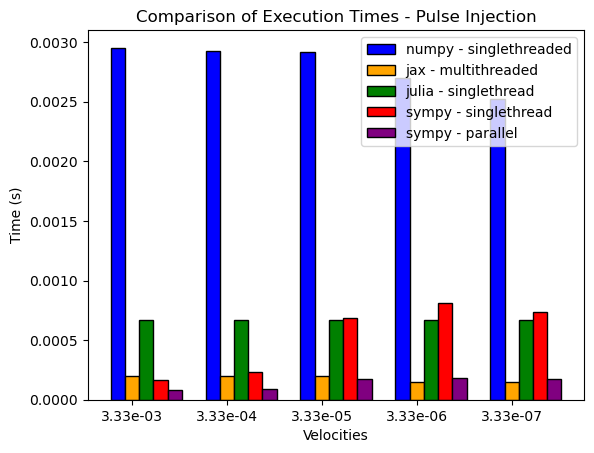

In [29]:
import matplotlib.pyplot as plt

# Define the data
labels = [np.format_float_scientific(v,2) for v in vs]


# Set the width of the bars
bar_width = 0.15

# Set the positions of the bars on the x-axis
r1 = np.arange(len(ts_np))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]
r5 = [x + bar_width for x in r4]

fig, ax = plt.subplots()

# Create the bar plot
ax.bar(r1, ts_np, color='blue', width=bar_width, edgecolor='black', label='numpy - singlethreaded')
ax.bar(r2, ts_jax, color='orange', width=bar_width, edgecolor='black', label='jax - multithreaded')
ax.bar(r3, tjulia, color='green', width=bar_width, edgecolor='black', label='julia - singlethread')
ax.bar(r4, ts_sym, color='red', width=bar_width, edgecolor='black', label='sympy - singlethread')
ax.bar(r5, ts_sym_par, color='purple', width=bar_width, edgecolor='black', label='sympy - parallel')

# Add xticks and labels
ax.set_xlabel('Velocities')
ax.set_ylabel('Time (s)')
ax.set_title('Comparison of Execution Times - Pulse Injection')
ax.set_xticks([r + bar_width for r in range(len(ts_np))], labels)

# Add a legend
ax.legend()

# Show the plot
fig.show()